<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/09_mason_waterbudget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Purpose:** Generate figures for the complete Mason Drainage water budget

In [ ]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
from scipy.stats import linregress

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ------------ #
# Custom Colors
# ------------ #

# for WB components
wb_palette = {
    'Qin': '#4BA3C3',     # Inflow
    'Precip (AF)': '#21A179',  # Precipitation
    'SR (AF)': '#D58936',      # SR
    'Qout': '#175676',    # Outflow
    'Evap (AF)': '#E46343',     # Evapotranspiration
    'Residual (AF)': 'none'    # Hollow for Residual
}

# ------------ #
# Custom Plot
# ------------ #

def theme_cust(ax):
    # Apply a classic style
    ax.set_facecolor('white')  # Panel background white
    ax.grid(visible=False)    # Turn off grid

    # Add a black border to the panel
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Customize axis text color
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    return ax

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/mason_final_water_budget.csv')
residual = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/mason_final_residual.csv')

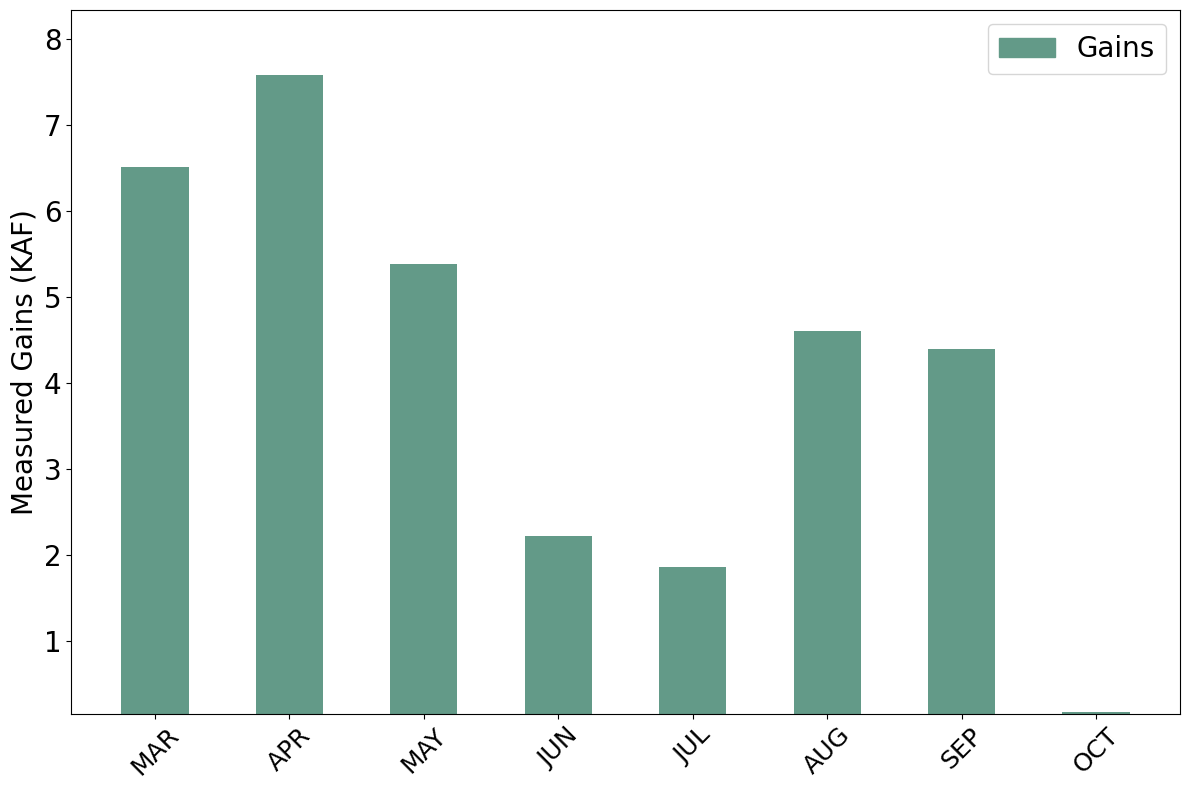

In [ ]:
# --------------------- #
# Figure : Unacounted Gains/Losses
# --------------------- #

residual_palette = {
    'Gains': '#639A88',  # Residual on inflow side (positive)
    'Losses': '#B57F50'  # Residual on outflow side (negative)
}

# Convert residuals to KAF
residual['Residual (KAF)'] = residual['Residual (AF)'] / 1000

# Extract month abbreviation from date
residual['Month_Abbr'] = pd.to_datetime(residual['Month'], errors='coerce').dt.strftime('%b').str.upper()

# Filter for months March through October
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
residual = residual[residual['Month_Abbr'].isin(months_order)]

# Convert Month_Abbr to categorical with the correct order
residual['Month_Abbr'] = pd.Categorical(residual['Month_Abbr'], categories=months_order, ordered=True)

# Sort the data by month
residual = residual.sort_values(by='Month_Abbr')


fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(residual['Month_Abbr']))
width = 0.5

# Plot residuals
for i, residual_value in enumerate(residual['Residual (KAF)']):
    color = residual_palette['Gains'] if residual_value > 0 else residual_palette['Losses']
    label = 'Gains' if residual_value > 0 else 'Losses'
    ax.bar(
        x[i], residual_value, width,
        color=color,
        label=label if label not in [handle.get_label() for handle in ax.get_legend_handles_labels()[0]] else None
    )


ax.set_xticks(x)
ax.set_xticklabels(residual['Month_Abbr'].astype(str), rotation=45, fontsize=18)
ax.axhline(0, color='black', linewidth=1, linestyle='--')
ax.set_ylabel("Measured Gains (KAF)", fontsize=20)
ax.set_title("", fontsize=20)
y_min = residual['Residual (KAF)'].min()
y_max = residual['Residual (KAF)'].max()
ax.tick_params(axis='y', labelsize=20)
ax.set_ylim(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1)
legend_handles = [
    mpatches.Patch(color=residual_palette['Gains'], label='Gains'),
    mpatches.Patch(color=residual_palette['Losses'], label='Losses')
]

legend_handles = [
    mpatches.Patch(color=residual_palette['Gains'], label='Gains')
]
ax.legend(handles=legend_handles, loc='best', fontsize = 20)
plt.tight_layout()
plt.show()


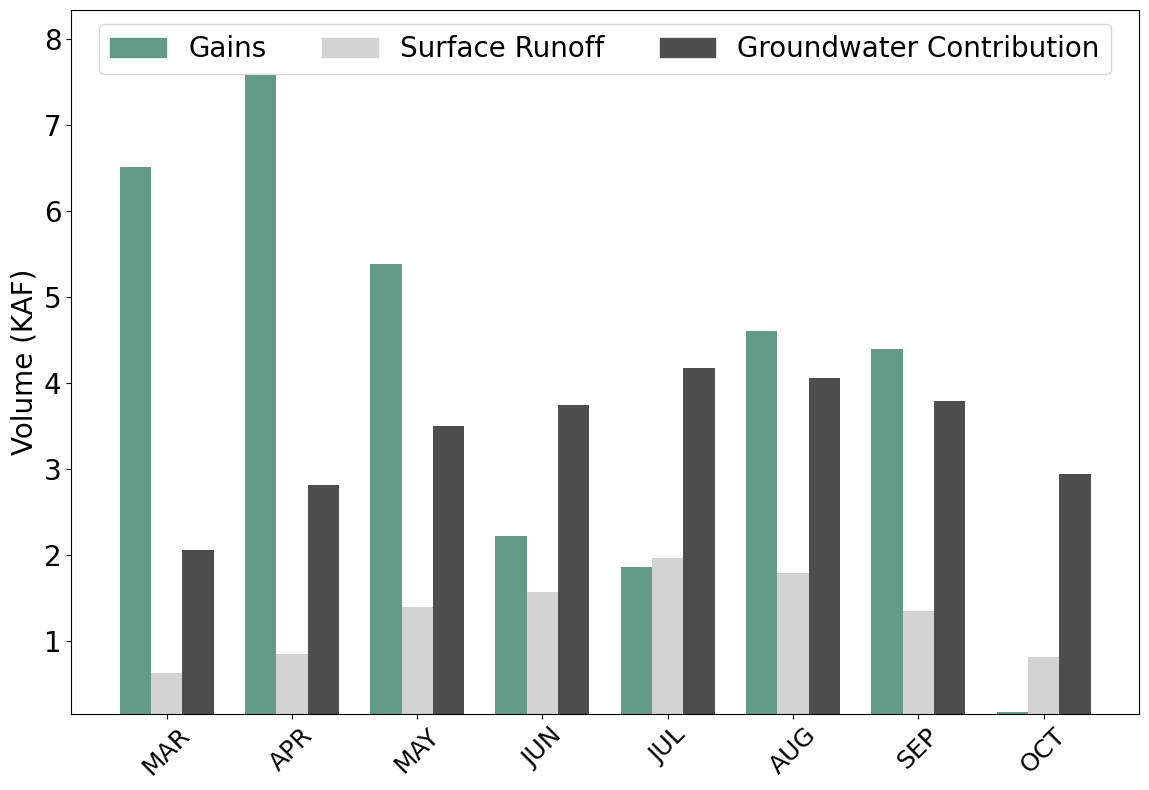

In [ ]:
# --------------------------------------------- #
# Figure: Comparison to Runoff and GW Estimates
# --------------------------------------------- #

# Load data
components = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/mason_final_water_budget.csv')
residual = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/mason_final_residual.csv')

# Convert to KAF
components['SR (KAF)'] = components['SR (AF)'] / 1000
residual['Residual (KAF)'] = residual['Residual (AF)'] / 1000
components['GW (KAF)'] = components['GW (KAF)']

# Filter and format months
valid_months = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
for df in [components, residual]:
    df['Month'] = pd.to_datetime(df['Month'])
    df['Month'] = df['Month'].dt.strftime('%b').str.upper()
    df['Month'] = pd.Categorical(df['Month'], categories=valid_months, ordered=True)

components = components[components['Month'].isin(valid_months)]
residual = residual[residual['Month'].isin(valid_months)]

# Define color palette
palette = {
    'Residual Inflow': '#639A88',  # Positive residual (inflow)
    'Residual Outflow': '#B57F50',  # Negative residual (outflow)
    'SR': '#D3D3D3',  # Light grey for surface runoff
    'GW': '#4D4D4D'   # Dark grey for groundwater
}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Data preparation
residual_data = residual.sort_values(by='Month')
sr_gw_data = components.sort_values(by='Month')

# Set up the x-axis positions
x = np.arange(len(valid_months))
width = 0.25  # Bar width

# Plot Residual (KAF)
for i, res_value in enumerate(residual_data['Residual (KAF)']):
    color = palette['Residual Inflow'] if res_value > 0 else palette['Residual Outflow']
    label = 'Residual Inflow' if res_value > 0 else 'Residual Outflow'
    ax.bar(
        x[i] - width, res_value, width, color=color,
        label=label if label not in [handle.get_label() for handle in ax.get_legend_handles_labels()[0]] else None
    )

# Plot SR (KAF)
ax.bar(x, sr_gw_data['SR (KAF)'], width, color=palette['SR'], label='Surface Runoff')

# Plot GW (KAF) (inverted values)
ax.bar(x + width, sr_gw_data['GW (KAF)'], width, color=palette['GW'], label='Groundwater Contribution')

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(valid_months, rotation=45, fontsize=18)
ax.axhline(0, color='black', linewidth=1, linestyle='--')
ax.set_ylabel("Volume (KAF)", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_title("", fontsize=20)

# Dynamic y-axis limits
y_min = min(residual_data['Residual (KAF)'].min(), sr_gw_data['GW (KAF)'].min(), sr_gw_data['SR (KAF)'].min())
y_max = max(residual_data['Residual (KAF)'].max(), sr_gw_data['GW (KAF)'].max(), sr_gw_data['SR (KAF)'].max())
ax.set_ylim(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1)

# Define legend handles
legend_handles = [
    mpatches.Patch(color=palette['Residual Inflow'], label='Gains'),
    mpatches.Patch(color=palette['SR'], label='Surface Runoff'),
    mpatches.Patch(color=palette['GW'], label='Groundwater Contribution')
]

# Add legend
ax.legend(handles=legend_handles, loc='upper center', ncol=4, fontsize=20)

# Adjust layout
plt.tight_layout()
plt.show()
